In [1]:


import sys
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EyeIK")
sys.path.insert(0, "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK")


import pickle as pkl
import numpy as np
import os
# import jax
from matplotlib import pyplot as plt
import json
from Proposed_model import *
from Reading_scene import *
from Geometry_Util import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Geometry_Util import *
def output_motion(hk, ek, micro_saccade, outpath, delay=0.0):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    for i in range(0, len(ek[0])):
        ek[0][i][0] -= delay
    for i in range(0, len(hk[0])):
        hk[0][i][0] -= delay
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pkl.dump(out, f, protocol=2)
    print(outpath)
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[:, index]
        else:
            angle = self.input_json["input_target_angle"][:, index]
        pos = directions_from_rotation_angles(np.array([angle]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])
class IntermnalModelFromModel_withTime:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
        self.time_arr = np.arange(0, gaze_arr.shape[1])/30
    def estimate_target_pose(self, time):
        index = np.argmin(np.abs(self.time_arr - time))
        if self.gaze_arr is not None:
            angle = self.gaze_arr[:, index]
        pos = directions_from_rotation_angles(np.array([angle]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window[1:2]], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

def get_gaze_inputs_naive(times, gaze_traj, dispersion_threshold = 3, duraiton_threshold=0.05):
    gaze_traj = rotation_angles_frome_positions(gaze_traj)
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(times, gaze_traj, dispersion_threshold, duraiton_threshold=duraiton_threshold)
    # gaze_fixations_angles = gaze_fixations[:, 1]
    # gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = times
    ts = ts - ts[0]
    input_sequence = []
    for i in range(0, len(gaze_fixations)):
        input_sequence.append([ts[gaze_fixations_intervals[i][0]], gaze_fixations[i, 0], gaze_fixations[i, 1]])
    input_sequence = np.array(input_sequence).T
    return input_sequence

def get_gaze_inputs(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_intervals = []
    for i in range(0, len(input_times)-1):
        input_intervals.append([input_times[i], input_times[i+1]])
    input_intervals.append([input_times[-1], input_times[-1]+100])
    # for each intervals of input
    
    for i in range(0, len(input_intervals)):
        # iterate through each gaze interval and find the first time stamp that is within 5 degrees of the input angle
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(gaze_fixations_intervals[j])
        interval_to_look = [gaze_fixations_index_in_interval[0][0], gaze_fixations_index_in_interval[-1][1]]
        starting_index = -1
        for j in range(interval_to_look[0], interval_to_look[1]):
            if abs(gaze_traj[j, 1] - input_angles[i]) < 1:
                starting_index = j
                break    
        if starting_index == -1:
            for j in range(interval_to_look[0], interval_to_look[1]):
                if abs(gaze_traj[j, 1] - input_angles[i]) < 5:
                    starting_index = j
                    break
        print(interval_to_look, starting_index)
        # plot the trajectory and the starting point
        # plt.plot(ts[interval_to_look[0]:interval_to_look[1]], gaze_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[interval_to_look[0]:interval_to_look[1]], head_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[starting_index], head_traj[starting_index, 1], 'r*')
        plt.show()
        
            

    
    for i in range(0, len(input_intervals)):
        continue
        # find the gaze fixations that are in the interval
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(j)
        # this is the interval of interest
        interval_of_interest = [gaze_fixations_intervals[gaze_fixations_index_in_interval[0]][0], gaze_fixations_intervals[gaze_fixations_index_in_interval[-1]][1]]
        fixations_angles_in_interval = gaze_fixations[gaze_fixations_index_in_interval, 0]
        # find the first angle within 5 degrees of the input angle in this interval
        index_of_first_angle_within_5_degrees = -1
        for j in range(0, len(fixations_angles_in_interval)):
            if abs(fixations_angles_in_interval[j] - input_angles[i]) < 5:
                index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                break
        if index_of_first_angle_within_5_degrees == -1:
            for j in range(0, len(fixations_angles_in_interval)):
                if abs(fixations_angles_in_interval[j] - input_angles[i]) < 10:
                    index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                    break
        print(input_angles[i])
        # plot the gaze trajectory
        plt.plot(ts[interval_of_interest[0]:interval_of_interest[1]], gaze_traj[interval_of_interest[0]:interval_of_interest[1], 1])
        # plot the gaze fixations from the first point to the point that is within 5 degrees of the input angle till the end of the gaze fixations
        plt.plot(ts[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1]], gaze_traj[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1], 1], 'r')
        plt.show()
        
# okay

In [4]:

JUGGLING_SCENE_DATA_ROOT = ".//reading_scenes"
JUGGLING_PKL_DATA_ROOT = ".//reading_output"
OUTPUT_ROOT = ".//output"
file_name = "reading_ver1"
# file_name = "HD_juggle_tennis_fast_output"

scene_json_filename = os.path.join(JUGGLING_SCENE_DATA_ROOT, file_name + ".json") 
motion_json_file_name = os.path.join(JUGGLING_PKL_DATA_ROOT, file_name + ".pkl")

scene_json = json.load(open(scene_json_filename, "r"))
motion_json = json.load(open(motion_json_file_name, "r"))

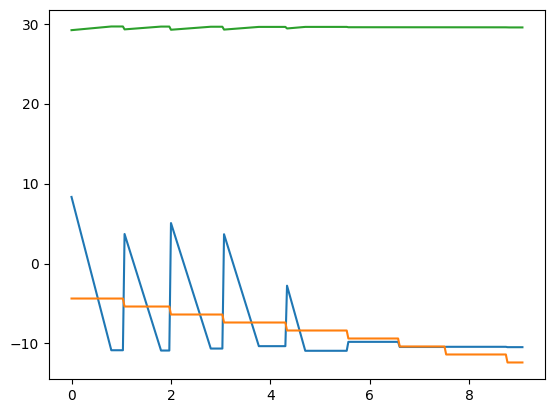

In [8]:

scene = ReadingScene(scene_json_filename, motion_json_file_name)
traj_temp = scene.get_gaze_trajectory()
traj = np.zeros(traj_temp.shape)
traj[:, 0] = traj_temp[:, 0]
traj[:, 1] = traj_temp[:, 1]
traj[:, 2] = traj_temp[:, 2]

times = np.arange(0, traj.shape[0])/30
input_sequence = get_gaze_inputs_naive(times, traj, 1, 0.01)
internal_model = InternalModelFromCapture({}, gaze_arr = input_sequence[1:].copy())
gaze_positions = []
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(input_sequence[1:][:, i].copy())
    
for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)

gaze_positions = np.array(gaze_positions)
gaze_positions = directions_from_rotation_angles(gaze_positions, np.ones([1, ]) * 100)

plt.plot(times, traj[:, 0])
plt.plot(times, traj[:, 1])
plt.plot(times, traj[:, 2])

# plt.plot(input_sequence[0], gaze_positions[:, 0])
# plt.plot(input_sequence[0], gaze_positions[:, 1])
# plt.plot(input_sequence[0], arr_gaze_pos[:, 2])




In [9]:
class BallsPositionsStructure:
    def __init__(self, jugglingScene:ReadingScene):
        self.jugglingScene = jugglingScene
        self.ballz = []
        for i in range(len(jugglingScene.object_pos)): # this is in local coordinate 
            self.ballz.append(self.jugglingScene.get_ball_i_trajectory(i))
        self.ball_to_look = self.jugglingScene.look_at_id
        self.time_arr = np.arange(0, self.ballz[0].shape[0])/30
    def estimate_target_pose(self, time):
        index = np.argmin(np.abs(self.time_arr - time))
        ball_id_to_look = self.ball_to_look[index]
        pos = self.ballz[ball_id_to_look][index]
        return pos

    def estimate_ball_i_pose(self, time):
        index = np.argmin(np.abs(self.time_arr - time))
        pos = self.ballz[0][index]
        return pos
    
    def get_base_pose(self):
        return np.array([0, 0, 100])
        


In [22]:
import networkx as nx
from Proposed_model import *
def dwell_factored_eye_strain_function(dwell_time, angle_j, angle0, angle1):
    # vanilla
    # dwell_time_factor1 = dwell_time
    # dwell_time_factor0 = np.maximum(1.5 - dwell_time, 0)
    # probably better?
    dwell_time_factor1 = np.maximum(0.0001, 1 - np.exp(-0.8*dwell_time)) # this is higher for shorter dwell times)
    dwell_time_factor0 = np.exp(-0.8*dwell_time) # this is higher for longer dwell times
    return dwell_time_factor1 * np.linalg.norm(angle_j - angle1) + dwell_time_factor0* np.linalg.norm(angle_j - angle0) + 0.4 *np.abs(angle_j)
def head_moving_cost_function(prev, current, dwell_time, laziness=0.6):
    # cost is the distance the the head has to move
    cost = laziness * np.linalg.norm(prev - current)
    if np.linalg.norm(prev - current) <= 4:
        cost = 0
    # but this cost is lowered in the direction of the midline
    # return np.maximum(0.0001, 1.5-np.log(dwell_time + 1)) * cost
    return np.exp(-0.8*dwell_time) * cost
def create_graph(self, laziness=0.5):
    gaze_trajectory_1 = self.input_gaze_pos_as_angles_per_frame
    gaze_trajectory_0 = self.input_gaze_pos_as_angles_per_frame_smoothed
    gaze_positions = self.gaze_pos_as_angles
    gaze_intervals = self.target_gaze_intervals_time
    graphs = []
    for dimension in range(0, 2):
        if dimension == 0:
            range_limit = 60
        else:
            range_limit = 30
        G = nx.DiGraph()
        list_plot = []
        for i in range(0, gaze_positions.shape[0]):
            t_index = int(np.ceil(gaze_intervals[i][0]/self.simulation_dt))
            t_index = min(t_index, gaze_trajectory_0.shape[0]-1)
            target_angle_0 = gaze_trajectory_0[t_index, dimension]
            target_angle_1 = gaze_trajectory_1[t_index, dimension]
            list_plot.append(target_angle_1)
            dwell_time = gaze_intervals[i][1] - gaze_intervals[i][0]
            for j in range(-range_limit, range_limit, 2):
                G.add_node((i, j), value=dwell_factored_eye_strain_function(dwell_time, j, target_angle_0, target_angle_1))
                if i > 0:
                    for j_prev in range(-range_limit, range_limit, 2):
                        G.add_edge((i-1, j_prev), (i, j), weight=head_moving_cost_function(j_prev, j, dwell_time, laziness=laziness))
        G.add_node((gaze_positions.shape[0], int(gaze_positions[-1][dimension])), value=0)
        for j_prev in range(-range_limit, range_limit, 2):
            G.add_edge((gaze_positions.shape[0]-1, j_prev), (gaze_positions.shape[0], int(gaze_positions[-1][dimension])), weight=0)
        graphs.append(G)
    return graphs
def optimize_head_pos(self, laziness=0.54):
    G_0, G_1 = create_graph(self, laziness)
    def combined_weight0(u, v, d):
        return G_0.nodes[v]['value'] + d['weight']
    def combined_weight1(u, v, d):
        return G_1.nodes[v]['value'] + d['weight']
    path_0 = nx.dijkstra_path(G_0, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][0])), combined_weight0)
    path_0 = np.array(path_0)[:, 1:2]
    path_1 = nx.dijkstra_path(G_1, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][1])), combined_weight1)
    path_1 = np.array(path_1)[:, 1:2]
    head_angles = np.concatenate([path_0, path_1], axis=1)
    head_pos = directions_from_rotation_angles(head_angles, 100)
    return head_angles, head_pos 
def dwell_factored_eye_strain_function(dwell_time, angle_j, angle0, angle1):
    # vanilla
    # dwell_time_factor1 = dwell_time
    # dwell_time_factor0 = np.maximum(1.5 - dwell_time, 0)
    # probably better?
    dwell_time_factor1 = np.maximum(0.0001, 1 - np.exp(-0.8*dwell_time)) # this is higher for shorter dwell times)
    dwell_time_factor0 = np.exp(-0.8*dwell_time) # this is higher for longer dwell times
    return dwell_time_factor1 * np.linalg.norm(angle_j - angle1) + dwell_time_factor0 * np.linalg.norm(angle_j - angle0) + 0.4 *np.abs(angle_j)
def head_moving_cost_function(prev, current, dwell_time, laziness=0.6):
    # cost is the distance the the head has to move
    cost = laziness * np.linalg.norm(prev - current)
    if np.linalg.norm(prev - current) <= 4:
        cost = 0
    # but this cost is lowered in the direction of the midline
    # return np.maximum(0.0001, 1.5-np.log(dwell_time + 1)) * cost
    return np.exp(-0.8*dwell_time) * cost
def process_saccade_timing(internal_model):
    switch_time = []
    switch_target = []
    ballz_id_at_time = internal_model.ball_to_look
    switch_time.append(0)
    switch_target.append(ballz_id_at_time[0])
    for i in range(1, len(ballz_id_at_time)):
        if ballz_id_at_time[i] != ballz_id_at_time[i-1]:
            switch_time.append((i-1)/30.0)
            switch_target.append(ballz_id_at_time[i-1])            
            switch_time.append(i/30.0)
            switch_target.append(ballz_id_at_time[i])
    # get the 
    switch_time.append((len(ballz_id_at_time)-1)/30.0)
    switch_target.append(ballz_id_at_time[-1])
    return switch_time, switch_target

def create_graph_pursuit(self, laziness=0.5):
    gaze_trajectory_1 = self.input_gaze_pos_as_angles_per_frame
    gaze_trajectory_0 = self.input_gaze_pos_as_angles_per_frame_smoothed
    gaze_positions = self.gaze_pos_as_angles
    gaze_intervals = self.target_gaze_intervals_time
    graphs = []
    for dimension in range(0, 2):
        if dimension == 0:
            range_limit = 60
        else:
            range_limit = 30
        G = nx.DiGraph()
        list_plot = []
        for i in range(0, gaze_positions.shape[0]):
            t_index = int(np.ceil(gaze_intervals[i][0]/self.simulation_dt))
            t_index = min(t_index, gaze_trajectory_0.shape[0]-1)
            target_angle_0 = gaze_trajectory_0[t_index, dimension]
            target_angle_1 = gaze_trajectory_1[t_index, dimension]
            list_plot.append(target_angle_1)
            if i % 2 == 0:
                # if i is the start of a pursuit, then it's just the interval
                dwell_time = 0.01
            else:
                # other wise it is the previous interval
                dwell_time = gaze_intervals[i][1] - gaze_intervals[i][0]
            for j in range(-range_limit, range_limit, 2):
                G.add_node((i, j), value=dwell_factored_eye_strain_function(dwell_time, j, target_angle_0, target_angle_1))
                if i > 0:
                    for j_prev in range(-range_limit, range_limit, 2):
                        G.add_edge((i-1, j_prev), (i, j), weight=head_moving_cost_function(j_prev, j, dwell_time, laziness=laziness))
        G.add_node((gaze_positions.shape[0], int(gaze_positions[-1][dimension])), value=0)
        for j_prev in range(-range_limit, range_limit, 2):
            G.add_edge((gaze_positions.shape[0]-1, j_prev), (gaze_positions.shape[0], int(gaze_positions[-1][dimension])), weight=head_moving_cost_function(j_prev, j, dwell_time))
        graphs.append(G)
    return graphs


def optimize_head_pos_with_pursuit(self, laziness=0.54):
    G_0, G_1 = create_graph_pursuit(self, laziness)
    def combined_weight0(u, v, d):
        return G_0.nodes[v]['value'] + d['weight']
    def combined_weight1(u, v, d):
        return G_1.nodes[v]['value'] + d['weight']
    path_0 = nx.dijkstra_path(G_0, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][0])), combined_weight0)
    path_0 = np.array(path_0)[:, 1:2]
    path_1 = nx.dijkstra_path(G_1, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][1])), combined_weight1)
    path_1 = np.array(path_1)[:, 1:2]
    head_angles = np.concatenate([path_0, path_1], axis=1)
    head_pos = directions_from_rotation_angles(head_angles, 100)
    return head_angles, head_pos 


## Proposed Model saccade only

In [11]:
scene = ReadingScene(scene_json_filename, motion_json_file_name)
ballz_internal_model = BallsPositionsStructure(scene)
saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model, reach_target_at_times=False, head_delay=0)
optimized_path = optimize_head_pos(saccade_generator)[1]
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimized_path)
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "task_{}_Proposed_graph_saccade_only.pkl".format(file_name)))
# print("Proposed error", np.sqrt(compare_kf_error_hk(gt_ek, ek_propsed, gt_hk, hk_proposed, name1="GT")))
# compare_kf_plot_hk(gt_ek, ek_propsed, gt_hk, hk_proposed, name2="Proposed", end=plot_ending)

(3,)
.//output\task_reading_ver1_Proposed_graph_saccade_only.pkl


## Pursuit Only

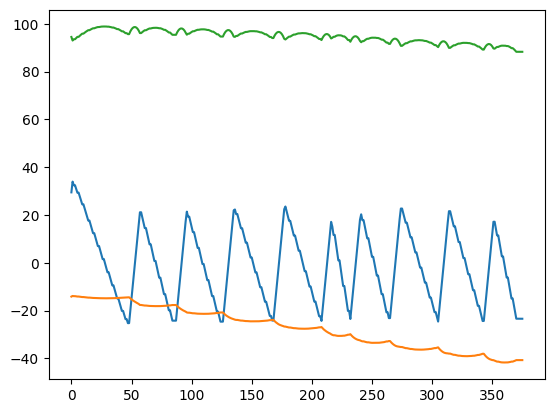

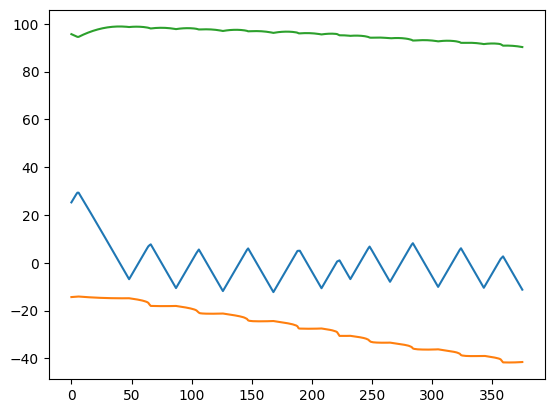

.//output\task_reading_ver1_Proposed_graph_smooth_pursuit_only.pkl


In [28]:
scene = ReadingScene(scene_json_filename, motion_json_file_name)
ballz_internal_model = BallsPositionsStructure(scene)

shift_times = np.array([0, len(ballz_internal_model.time_arr)])/30 # shift at time 0
shift_indexes = np.array([0, 1]) # look at index 0
shift_targets_pos = np.array([gaze_positions[0], gaze_positions[10]]) # look at the first gaze position
saccade_generator = Proposed_saccade_generator_with_graph_smooth_pursuit(shift_times, shift_targets_pos, shift_indexes, ballz_internal_model, reach_target_at_times=False, head_delay=0, do_saccade=False)
optimized_path = optimize_head_pos(saccade_generator)[1]
plot_optimized_path = np.array(optimized_path)
# plt.plot(plot_optimized_path[:, 0])
# plt.plot(plot_optimized_path[:, 1])
# plt.plot(plot_optimized_path[:, 2])

# plt.show()
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimized_path)
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "task_{}_Proposed_graph_smooth_pursuit_only.pkl".format(file_name)))

## only use the start time to compute head position

In [13]:
def process_saccade_timing_start_only(internal_model):
    switch_time = []
    switch_target = []
    ballz_id_at_time = internal_model.ball_to_look
    switch_time.append(0)
    switch_target.append(ballz_id_at_time[0])
    for i in range(1, len(ballz_id_at_time)):
        if ballz_id_at_time[i] != ballz_id_at_time[i-1]:
            switch_time.append(i/30)
            switch_target.append(ballz_id_at_time[i])
    # get the 
    return switch_time, switch_target

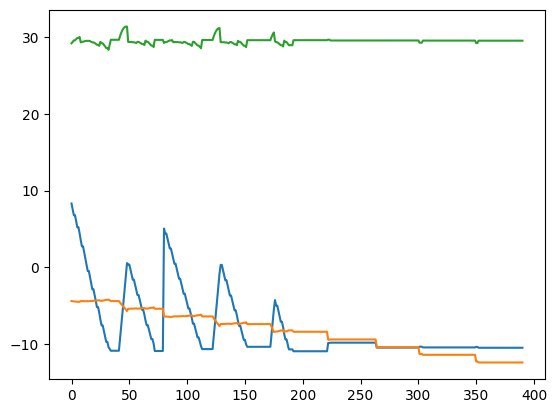

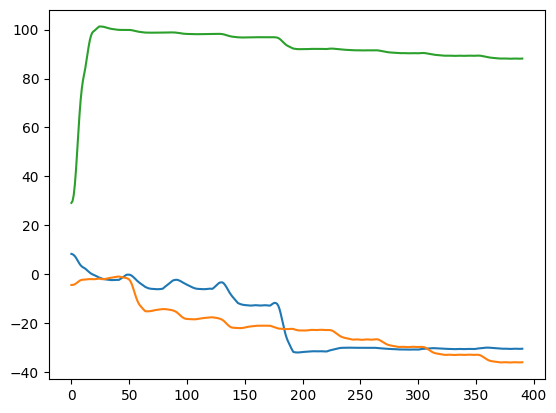

.//output\task_reading_ver1_Proposed_graph_smooth_pursuit_with_saccade_only_consider_start.pkl


In [14]:
ballz_internal_model = BallsPositionsStructure(scene)

# the input needs to have
# 2. the time and target for each gaze shifts (i.e. which ball to shift to at which time)
# 3. the positions of each balls (ballz_internal_model)

# shift times should be 
shift_times, shift_indexes = process_saccade_timing_start_only(ballz_internal_model)
shift_targets_pos = []
for i in range(0, len(shift_indexes)):
    shift_targets_pos.append(ballz_internal_model.estimate_target_pose(shift_indexes[i]))
saccade_generator = Proposed_saccade_generator_with_graph_smooth_pursuit(shift_times, shift_targets_pos, shift_indexes, ballz_internal_model, reach_target_at_times=False, head_delay=0)
optimized_path = optimize_head_pos(saccade_generator)[1]
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimized_path)
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "task_{}_Proposed_graph_smooth_pursuit_with_saccade_only_consider_start.pkl".format(file_name)))

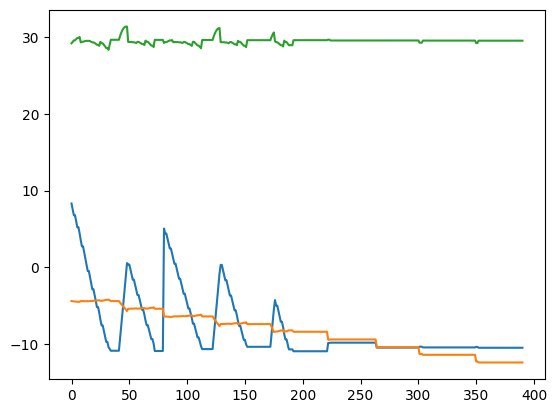

In [15]:
plt.show()
ek_propsed_out = np.array(ek_propsed)[0]
plt.plot(ek_propsed_out[:, 1])
plt.plot(ek_propsed_out[:, 2])
plt.plot(ek_propsed_out[:, 3])


## Use both the start and end position to compute head position

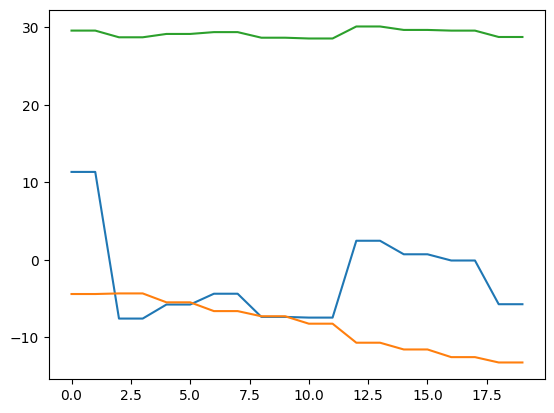

In [27]:
plt.plot(np.array(shift_targets_pos))

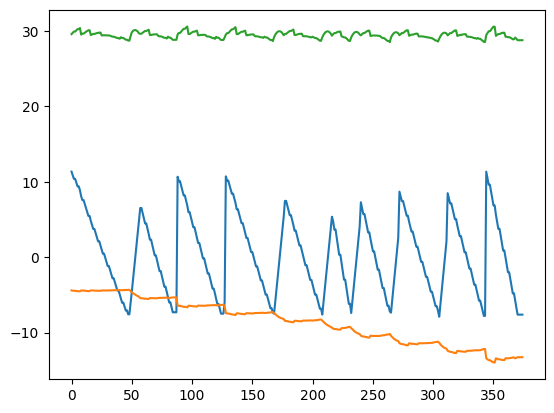

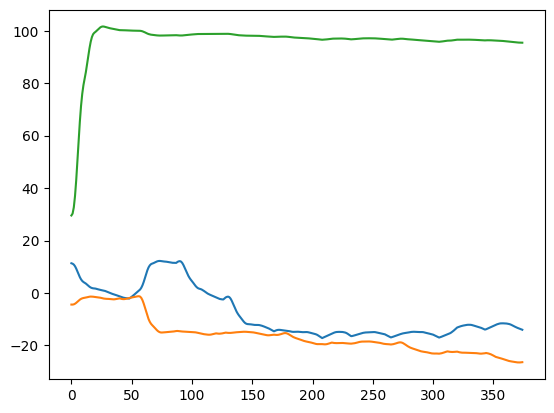

.//output\task_reading_ver1_Proposed_graph_smooth_pursuit_with_saccade_consider_start_and_end_pos.pkl


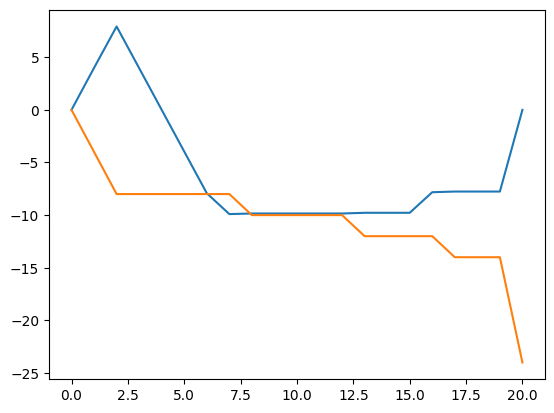

In [24]:
scene = ReadingScene(scene_json_filename, motion_json_file_name)
ballz_internal_model = BallsPositionsStructure(scene)

# the input needs to have
# 2. the time and target for each gaze shifts (i.e. which ball to shift to at which time)
# 3. the positions of each balls (ballz_internal_model)

# shift times should be 
shift_times, shift_indexes = process_saccade_timing(ballz_internal_model)
shift_targets_pos = []
for i in range(0, len(shift_indexes)):
    shift_targets_pos.append(ballz_internal_model.estimate_target_pose(shift_indexes[i]))
saccade_generator = Proposed_saccade_generator_with_graph_smooth_pursuit(shift_times, shift_targets_pos, shift_indexes, ballz_internal_model, reach_target_at_times=False, head_delay=0)
# this will slightly modify the code to extend the time to the end of the last gaze shift
optimized_path = optimize_head_pos_with_pursuit(saccade_generator, laziness=1.5)[1]
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimized_path)
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "task_{}_Proposed_graph_smooth_pursuit_with_saccade_consider_start_and_end_pos.pkl".format(file_name)))
optimized_path_angles = rotation_angles_frome_positions(optimized_path)
plt.plot(optimized_path_angles)

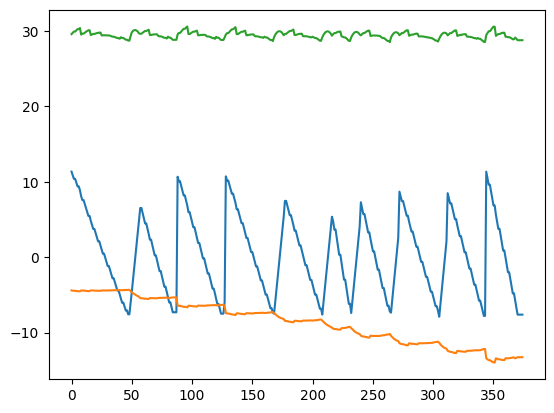

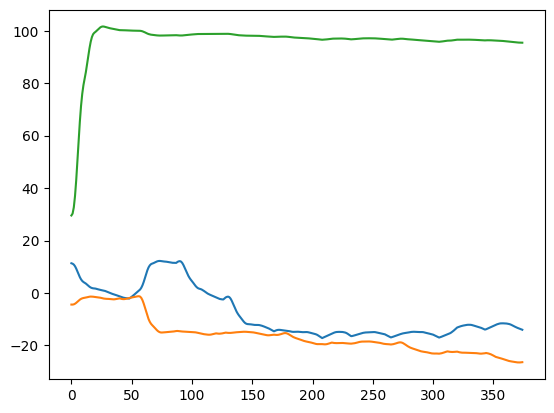

.//output\task_reading_ver1_Proposed_graph_smooth_pursuit_with_saccade_consider_start_and_end_pos.pkl


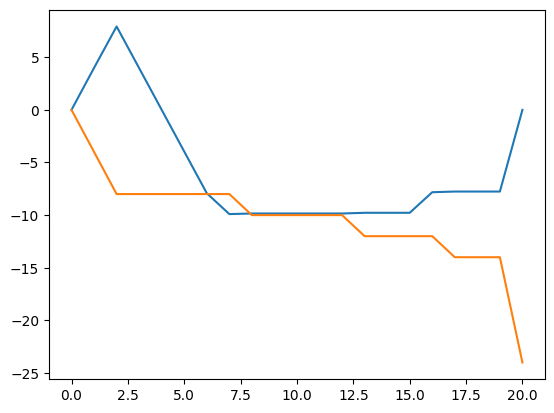

In [21]:
scene = ReadingScene(scene_json_filename, motion_json_file_name)
ballz_internal_model = BallsPositionsStructure(scene)

# the input needs to have
# 2. the time and target for each gaze shifts (i.e. which ball to shift to at which time)
# 3. the positions of each balls (ballz_internal_model)

# shift times should be 
shift_times, shift_indexes = process_saccade_timing(ballz_internal_model)
shift_targets_pos = []
for i in range(0, len(shift_indexes)):
    shift_targets_pos.append(ballz_internal_model.estimate_target_pose(shift_indexes[i]))
saccade_generator = Proposed_saccade_generator_with_graph_smooth_pursuit(shift_times, shift_targets_pos, shift_indexes, ballz_internal_model, reach_target_at_times=False, head_delay=0)
# this will slightly modify the code to extend the time to the end of the last gaze shift
optimized_path = optimize_head_pos_with_pursuit(saccade_generator, laziness=5)[1]
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimized_path)
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "task_{}_Proposed_graph_smooth_pursuit_with_saccade_consider_start_and_end_pos.pkl".format(file_name)))
optimized_path_angles = rotation_angles_frome_positions(optimized_path)
plt.plot(optimized_path_angles)

## Eye Catch

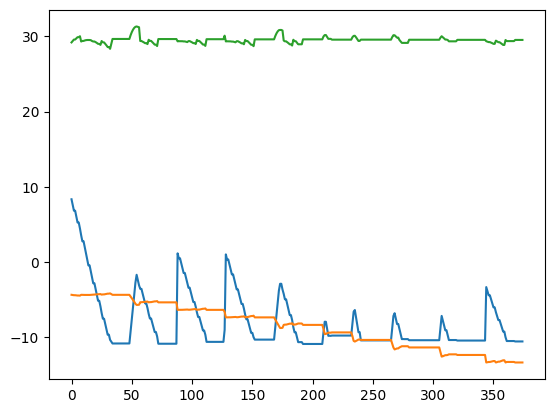

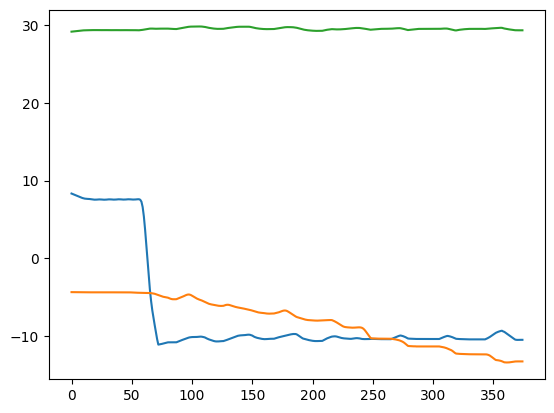

.//output\task_reading_ver1_EYECatch.pkl


In [19]:
scene = ReadingScene(scene_json_filename, motion_json_file_name)
ballz_internal_model = BallsPositionsStructure(scene)

# the input needs to have
# 2. the time and target for each gaze shifts (i.e. which ball to shift to at which time)
# 3. the positions of each balls (ballz_internal_model)

# shift times should be 
shift_times, shift_indexes = process_saccade_timing(ballz_internal_model)
shift_targets_pos = []
for i in range(0, len(shift_indexes)):
    shift_targets_pos.append(ballz_internal_model.estimate_target_pose(shift_indexes[i]))
saccade_generator
saccade_generator = Proposed_saccade_generator_with_graph_smooth_pursuit(shift_times, shift_targets_pos, shift_indexes, ballz_internal_model, reach_target_at_times=False, head_delay=0)

optimized_EYECatch = np.array(shift_targets_pos)
# this will slightly modify the code to extend the time to the end of the last gaze shift
ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimized_EYECatch)
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "task_{}_EYECatch.pkl".format(file_name)))

## Pejsa

In [12]:
from Pejsa_implementation import *
scene = JugglingScene(scene_json_filename, motion_json_file_name)
ballz_internal_model = BallsPositionsStructure(scene)

# the input needs to have
# 2. the time and target for each gaze shifts (i.e. which ball to shift to at which time)
# 3. the positions of each balls (ballz_internal_model)
shift_times, shift_indexes = process_saccade_timing(ballz_internal_model)
shift_targets_pos = []
for i in range(0, len(shift_indexes)):
    shift_targets_pos.append(ballz_internal_model.estimate_target_pose(shift_indexes[i]))

saccade_generator = Pejsa_SacccadeGenerator(shift_times, shift_targets_pos, shift_indexes, internal_model, 0.5)
ek_pejsa, hk_pejsa, micro_saccade_pejsa = saccade_generator.compute()
output_motion(hk_pejsa, ek_pejsa, micro_saccade_pejsa, os.path.join(OUTPUT_ROOT, "task_{}_Pejsa.pkl".format(file_name)))


.//output\task_cascade_long_output_Pejsa.pkl
